### Note: Just started hacking on this, the code is a mess =D

---

# Comparing Estimators on a few toy datasets
Inspired by this excellent sample from sklearn: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import collections

from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

Create a few toy datasets for binary classification. 'Blobs' is linearly seperable, the others are not.

In [2]:
n_samples = 100
random_state = 0

datasets = collections.OrderedDict([
    ('Blobs', make_blobs(n_samples=n_samples, centers=2, cluster_std=0.5, random_state=random_state)),
    ('Circles', make_circles(n_samples=n_samples, factor=.5, noise=.03, random_state=random_state)),
    ('Moons', make_moons(n_samples=n_samples, noise=.03, random_state=random_state))
])

Let's plot them. Points from the first class will be colored blue, and the second class will be colored green.

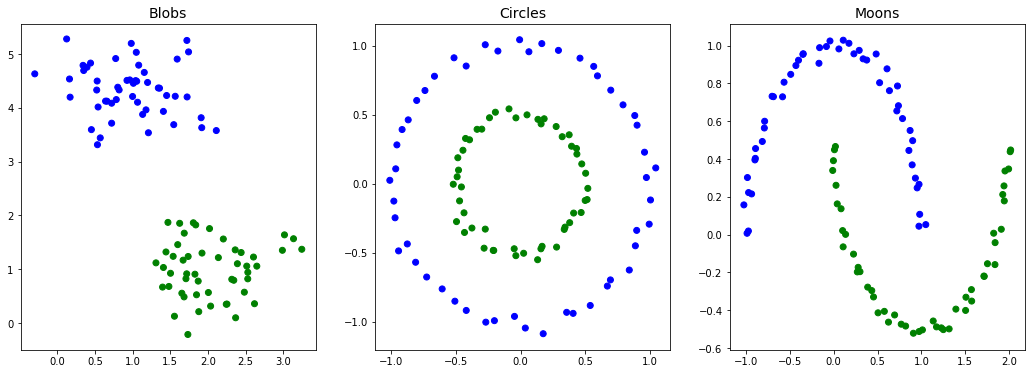

In [3]:
figure = plt.figure(figsize=(18, 6))
colors = np.array(["blue", "green"])
i = 0
for name in datasets:
    X, y = datasets[name]
    i += 1
    ax = plt.subplot(1, len(datasets), i)
    plt.scatter(X[:, 0], X[:, 1], color=colors[y].tolist())
    plt.title(name, fontsize=14)
plt.show()

This method creates a number of estimators for us to experiment with. It takes a description of the features to use as a parameter. We'll create this description separately for each dataset, later in the notebook.

In [4]:
def make_estimators(feature_columns, n_classes):

    estimators = collections.OrderedDict([

        ('Linear', tf.estimator.LinearClassifier(
            feature_columns=feature_columns, 
            n_classes=n_classes,
            model_dir="./graphs/canned/linear"
        )),
    
        ('Deep', tf.estimator.DNNClassifier(
            hidden_units=[128, 128],
            feature_columns=feature_columns, 
            n_classes=n_classes,
            model_dir="./graphs/canned/deep"
        )),
        
        # Note: the value of this model is when we 
        # use different types of feature engineering
        # for the linear and dnn features
        # see the Wide and Deep tutorial on tensorflow.org
        # a non-trivial use-case.
        ('Wide_Deep', tf.estimator.DNNLinearCombinedClassifier(
            dnn_hidden_units=[100, 50],
            linear_feature_columns=feature_columns, 
            dnn_feature_columns=feature_columns,
            n_classes=n_classes,
            model_dir="./graphs/canned/wide_n_deep"
        )),
        
    ])
    
    return estimators

Calling predict on an estimator returns a generator object. For convenience, this method will give us a list of predictions. Here, we're returning the probabilities for each class.

In [5]:
def get_predictions(estimator, input_fn):
    predictions = []
    for prediction in estimator.predict(input_fn=input_fn):
        probs = prediction['probabilities']
        # If instead you'd like to return just the predicted class index
        # you can use this code.
        #cls = np.argmax(probs)
        #predictions.append(cls)
        predictions.append(probs)
    return predictions

Let's train each Estimator on each dataset, and record the predictions for each test point, and the evaluation (which contains stats like overall accuracy) as we go.

In [6]:
# We'll use these objects to store results. 
# Each maps from a tuple of (dataset_name, estimator_name) to the results.
evaluations = {}
predictions = {}
mesh_predictions = {}

# ===
# Parameters
# ===

# Training sets
steps = 100

# Step size in the mesh
h = .02  

for ds_name in datasets:
    
    # This is the entire dataset
    X, y = datasets[ds_name]
        
    # Standardize values to 0 mean and unit standard deviation
    X = StandardScaler().fit_transform(X)
    
    # Split in to train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    n_features = X_train.shape[1]
    
    n_classes = len(np.unique(y_train))
    
    feature_columns = [tf.feature_column.numeric_column('x', shape=n_features)]
    
    estimators = make_estimators(feature_columns, n_classes)
    
    # Create a mesh grid.
    # The idea is we'll make a prediction for every coordinate
    # in this space, so we display them later.
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    for es_name in estimators:
        
        print("Training", es_name, "on", ds_name,"...")
        
        estimator = estimators[es_name]
        
        train_input_fn = tf.estimator.inputs.numpy_input_fn(
            {'x': X_train},
            y_train, 
            num_epochs=None, # Repeat forever
            shuffle=True
        )

        test_input_fn = tf.estimator.inputs.numpy_input_fn(
            {'x': X_test},
            y_test, 
            num_epochs=1, # Repeat forever
            shuffle=False
        )
        
        # An input function for each point on the mes
        surface_input_fn = tf.estimator.inputs.numpy_input_fn(
            {'x': np.c_[xx.ravel(), yy.ravel()]},
            num_epochs=1, # Repeat forever
            shuffle=False
        )
        
        estimator.train(train_input_fn, steps=steps)
        
        # evaluate on the test data
        evaluation = estimator.evaluate(test_input_fn)
        
        # store the evaluation for later
        evaluations[(ds_name, es_name)] = evaluation
        
        # make a prediction for every coordinate in the mesh
        predictions = np.array(get_predictions(estimator, input_fn=surface_input_fn))
        
        # store the mesh predictions for later
        mesh_predictions[(ds_name, es_name)] = predictions
        
print("Finished")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': './graphs/canned/linear', '_save_summary_steps': 100}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': './graphs/canned/deep', '_save_summary_steps': 100}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': './graphs/canned/w

INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': './graphs/canned/linear', '_save_summary_steps': 100}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': './graphs/canned/deep', '_save_summary_steps': 100}
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_tf_random_seed': 1, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_save_checkpoints_steps': None, '_model_dir': './graphs/canned/wide_n_deep', '_save_summary_steps': 10

Let's plot the results.

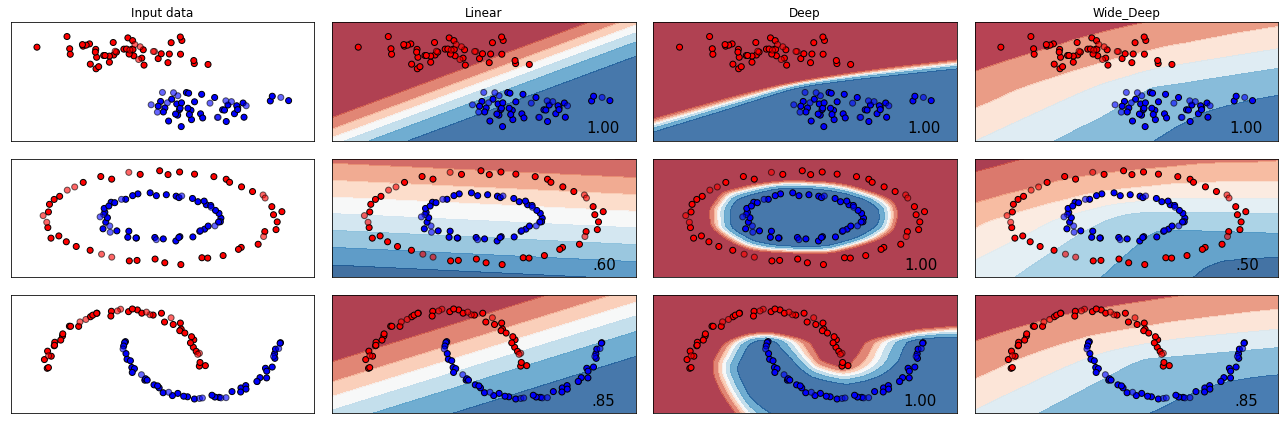

In [7]:
n_datasets = len(datasets)
n_estimators = len(estimators)
figure = plt.figure(figsize=(n_datasets * 6, n_estimators * 2))

plot_num = 1
row = 0

for ds_name in datasets:
    
    X, y = datasets[ds_name]
    
    # Standardize values to 0 mean and unit standard deviation
    X = StandardScaler().fit_transform(X)
    
    # Split in to train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
    # Step size in the mesh
    h = .02  

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the dataset
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(estimators) + 1, plot_num)
    plot_num += 1

    if row == 0: ax.set_title("Input data")
        
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    
    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
        
    col = 1
    
    for es_name in estimators:

        evaluation = evaluations[(ds_name,es_name)]
        accuracy = evaluation["accuracy"]

        ax = plt.subplot(len(datasets), len(estimators) + 1, plot_num)
        plot_num += 1

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max]. 
        Z = mesh_predictions[(ds_name, es_name)][:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        
        if row == 0: ax.set_title(es_name)
            
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % accuracy).lstrip('0'),
                size=15, horizontalalignment='right')
        
        col += 1
        
    row += 1
   
        
plt.tight_layout()
plt.show()

Let's visualize the results in TensorBoard.